In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os, os.path, pickle, sys

from scipy import stats

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, Normalize
from matplotlib import cm

from datetime import datetime

In [2]:
sys.path.append("/Users/hn/Documents/00_GitHub/Ag_Others/Ehsan/Wheat/")
import wheat_core as wc

In [3]:
data_dir_base = "/Users/hn/Documents/01_research_data/Ehsan/wheat/"
wheat_reOrganized = data_dir_base + "wheat_reOrganized/"

wheat_plot_dir = data_dir_base + "plots/GDD_precip/"
os.makedirs(wheat_plot_dir, exist_ok=True)

In [4]:
data_ = pd.read_pickle(wheat_reOrganized + "average_and_seperate_varieties.sav")
data_.keys()

dict_keys(['averaged_varieties', 'separate_varieties', 'dates', 'source_code', 'Author', 'Date'])

In [5]:
averaged_varieties = data_["averaged_varieties"]
separate_varieties = data_["separate_varieties"]
dates = data_["dates"]

separate_varieties.head(2)

,location,year,variety,yield,1_tavg,2_tavg,3_tavg,4_tavg,5_tavg,6_tavg,...,16_vs,17_vs,18_vs,19_vs,20_vs,21_vs,22_vs,23_vs,24_vs,25_vs
0,Almira,2005,Alpowa,43.9,7.725714,14.655,11.125714,14.511429,14.647143,12.345,...,3.3,2.528571,2.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Almira,2005,Alturas,37.7,7.725714,14.655,11.125714,14.511429,14.647143,12.345,...,3.3,2.528571,2.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
averaged_varieties.head(2)

,location,year,yield,1_tavg,2_tavg,3_tavg,4_tavg,5_tavg,6_tavg,7_tavg,...,16_vs,17_vs,18_vs,19_vs,20_vs,21_vs,22_vs,23_vs,24_vs,25_vs
0,Almira,2005,42.088889,7.725714,14.655000,11.125714,14.511429,14.647143,12.345000,18.738571,...,3.300000,2.528571,2.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Almira,2006,71.019048,8.555714,12.201429,9.725000,12.675714,21.397857,12.253571,16.030714,...,2.457143,3.633333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# GDD and Precip model

replace NAs in gdd and precip. since after harvest date, they are not measured, but those columns exist because of other location, year combos!

In [7]:
# grab gdd and precip
x_vars = [x for x in separate_varieties.columns if ("gdd" in x) or ("precip" in x)]

# drop dgdd
x_vars = [x for x in x_vars if not ("dgdd" in x)]
x_vars[:3]

['1_gdd', '2_gdd', '3_gdd']

## 4 seasons

4 season might be reasonable to try?

In [8]:
wanted_cols = ['location', 'year', 'variety', 'yield'] + x_vars
df = separate_varieties[wanted_cols].copy()
df = pd.merge(df, dates[["year", "location", "season_length"]], on = ["year", "location"], how="left")

In [9]:
subseason_count = 4
df["season_length_weeks"] = df["season_length"] / 7
df["week_count_per_season"] = round(df["season_length_weeks"] / subseason_count)
df["week_count_per_season"] = df["week_count_per_season"].astype(int)

df.fillna(value=0, inplace=True)
df.head(2)

,location,year,variety,yield,1_gdd,2_gdd,3_gdd,4_gdd,5_gdd,6_gdd,...,19_precip,20_precip,21_precip,22_precip,23_precip,24_precip,25_precip,season_length,season_length_weeks,week_count_per_season
0,Almira,2005,Alpowa,43.9,54.08,102.585,77.88,101.58,102.53,86.415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124,17.714286,4
1,Almira,2005,Alturas,37.7,54.08,102.585,77.88,101.58,102.53,86.415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124,17.714286,4


In [11]:
dict_season = {"location" : list(df["location"]),
               "year" : list(df["year"]),
               "variety" : list(df["variety"]),
               "yield" : list(df["yield"]),
              }
df_season = pd.DataFrame(dict_season)
df_season.head(2)

,location,year,variety,yield
0,Almira,2005,Alpowa,43.9
1,Almira,2005,Alturas,37.7


In [13]:
desired_features = ["gdd", "precip"]
# form new season-wise columns
pre_var = ["s" + str(x) + "_" for x in list(range(1, subseason_count+1))]
pre_var = pre_var * len(desired_features)
post_feature = sorted(desired_features * 4)
season_cols = [x + y for x, y in zip(pre_var, post_feature)]

# add new columns to df_season
df_season[season_cols] = -10
df_season.head(2)

,location,year,variety,yield,s1_gdd,s2_gdd,s3_gdd,s4_gdd,s1_precip,s2_precip,s3_precip,s4_precip
0,Almira,2005,Alpowa,43.9,-10,-10,-10,-10,-10,-10,-10,-10
1,Almira,2005,Alturas,37.7,-10,-10,-10,-10,-10,-10,-10,-10


In [14]:
%%time

# we have to do a for-loop
for idx in df_season.index:
    curr_df = df.loc[idx].copy()
    week_count_per_season = curr_df["week_count_per_season"]
    # print (curr_df["location"] + " - " + str(curr_df["year"]))
    
    # The cuts between each season
    cut_offs = list(week_count_per_season * range(1, subseason_count+1))
    # since there is only 25 weeks worth of data
    # replace the last cutoff to 25 so that last season
    # contains everything.
    cut_offs[-1] = 25
    # takes care of first season
    cut_offs = [0] + cut_offs
    
    for season_ in range(1, subseason_count+1):
        start_week = cut_offs[season_-1] + 1
        end_week   = cut_offs[season_] + 1
        for var_ in desired_features:
            weekly_cols = [str(x) + "_" + var_ for x in range(start_week, end_week)]
            df_season.loc[idx, "s"+str(season_)+"_"+var_] = curr_df[weekly_cols].sum()

df_season.head(2)

CPU times: user 2.39 s, sys: 8.86 ms, total: 2.4 s
Wall time: 2.4 s


,location,year,variety,yield,s1_gdd,s2_gdd,s3_gdd,s4_gdd,s1_precip,s2_precip,s3_precip,s4_precip
0,Almira,2005,Alpowa,43.9,336.125,418.83,514.615,912.34,51.0,28.3,11.4,11.4
1,Almira,2005,Alturas,37.7,336.125,418.83,514.615,912.34,51.0,28.3,11.4,11.4


In [15]:
df_season[(df_season["location"] == "Almira") & (df_season["variety"] == "Alpowa")]

,location,year,variety,yield,s1_gdd,s2_gdd,s3_gdd,s4_gdd,s1_precip,s2_precip,s3_precip,s4_precip
0,Almira,2005,Alpowa,43.900000,336.125,418.830,514.615,912.340,51.0,28.3,11.4,11.4
6,Almira,2006,Alpowa,69.966667,302.105,465.350,570.600,676.005,6.7,59.0,10.8,3.0
13,Almira,2007,Alpowa,37.966667,350.365,438.165,551.350,755.525,9.4,21.6,4.2,8.2
21,Almira,2008,Alpowa,53.166667,335.240,404.755,585.780,648.030,4.3,15.4,2.3,0.0
30,Almira,2009,Alpowa,57.233333,282.850,501.150,530.030,711.260,21.6,6.3,2.5,15.9
39,Almira,2010,Alpowa,52.066667,332.305,463.740,662.290,641.610,14.8,85.3,9.8,2.9
48,Almira,2011,Alpowa,56.133333,346.370,518.630,681.320,572.580,67.8,19.8,6.4,0.0
57,Almira,2012,Alpowa,45.300000,416.240,528.245,801.195,510.430,23.5,64.0,22.2,0.0
67,Almira,2013,Alpowa,61.433333,447.190,507.205,791.245,717.160,9.6,48.0,5.0,19.3
78,Almira,2014,Alpowa,21.633333,386.235,449.195,643.225,878.585,8.2,11.9,12.9,37.8


In [16]:
locations = df.location.unique()
varieties = df.variety.unique()

cols_= ["location", "wheat", "start_year", "end_year"]
years_loc_timeSpan = pd.DataFrame(columns = cols_, index = range(len(locations)*len(varieties)))
counter = 0

for a_loc in locations:
    for wheat in varieties:
        A = df[(df["location"] == a_loc) & (df["variety"] == wheat)].copy()
        years_loc_timeSpan.loc[counter, cols_] = [a_loc, wheat, A.year.min(), A.year.max()]
        counter+=1

In [17]:
A = df[(df["location"] == "Almira") & (df["variety"] == "Alpowa")].copy()
A

,location,year,variety,yield,1_gdd,2_gdd,3_gdd,4_gdd,5_gdd,6_gdd,...,19_precip,20_precip,21_precip,22_precip,23_precip,24_precip,25_precip,season_length,season_length_weeks,week_count_per_season
0,Almira,2005,Alpowa,43.900000,54.080,102.585,77.880,101.580,102.530,86.415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124,17.714286,4
6,Almira,2006,Alpowa,69.966667,59.890,85.410,68.075,88.730,149.785,85.775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114,16.285714,4
13,Almira,2007,Alpowa,37.966667,70.370,79.485,88.590,111.920,92.410,118.160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116,16.571429,4
21,Almira,2008,Alpowa,53.166667,54.830,72.425,75.765,132.220,106.030,116.475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114,16.285714,4
30,Almira,2009,Alpowa,57.233333,69.580,60.815,69.535,82.920,108.880,134.765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113,16.142857,4
39,Almira,2010,Alpowa,52.066667,42.385,94.090,70.175,61.175,64.480,111.780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132,18.857143,5
48,Almira,2011,Alpowa,56.133333,45.210,53.455,74.320,84.420,88.965,83.865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,131,18.714286,5
57,Almira,2012,Alpowa,45.300000,84.310,57.090,90.770,102.770,81.300,100.825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127,18.142857,5
67,Almira,2013,Alpowa,61.433333,47.345,69.430,95.530,134.900,99.985,73.675,...,4.2,0.0,0.0,0.0,0.0,0.0,0.0,136,19.428571,5
78,Almira,2014,Alpowa,21.633333,88.525,77.975,109.620,110.115,103.170,126.670,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122,17.428571,4


In [18]:
tick_legend_FontSize = 15
params = {"legend.fontsize": tick_legend_FontSize,  # medium, large
          "legend.title_fontsize" : tick_legend_FontSize * 1.3,
          "legend.markerscale" : 2,
          # 'figure.figsize': (6, 4),
          "axes.labelsize": tick_legend_FontSize * 1,
          "axes.titlesize": tick_legend_FontSize * 2,
          "xtick.labelsize": tick_legend_FontSize * 1,
          "ytick.labelsize": tick_legend_FontSize * 1,
          "axes.titlepad": 10}
plt.rcParams.update(params)

In [44]:
season_gdd_cols = [x for x in df_season.columns if "gdd" in x]
season_precip_cols = [x for x in df_season.columns if "precip" in x]

['yield',
 's1_gdd',
 's2_gdd',
 's3_gdd',
 's4_gdd',
 's1_precip',
 's2_precip',
 's3_precip',
 's4_precip']

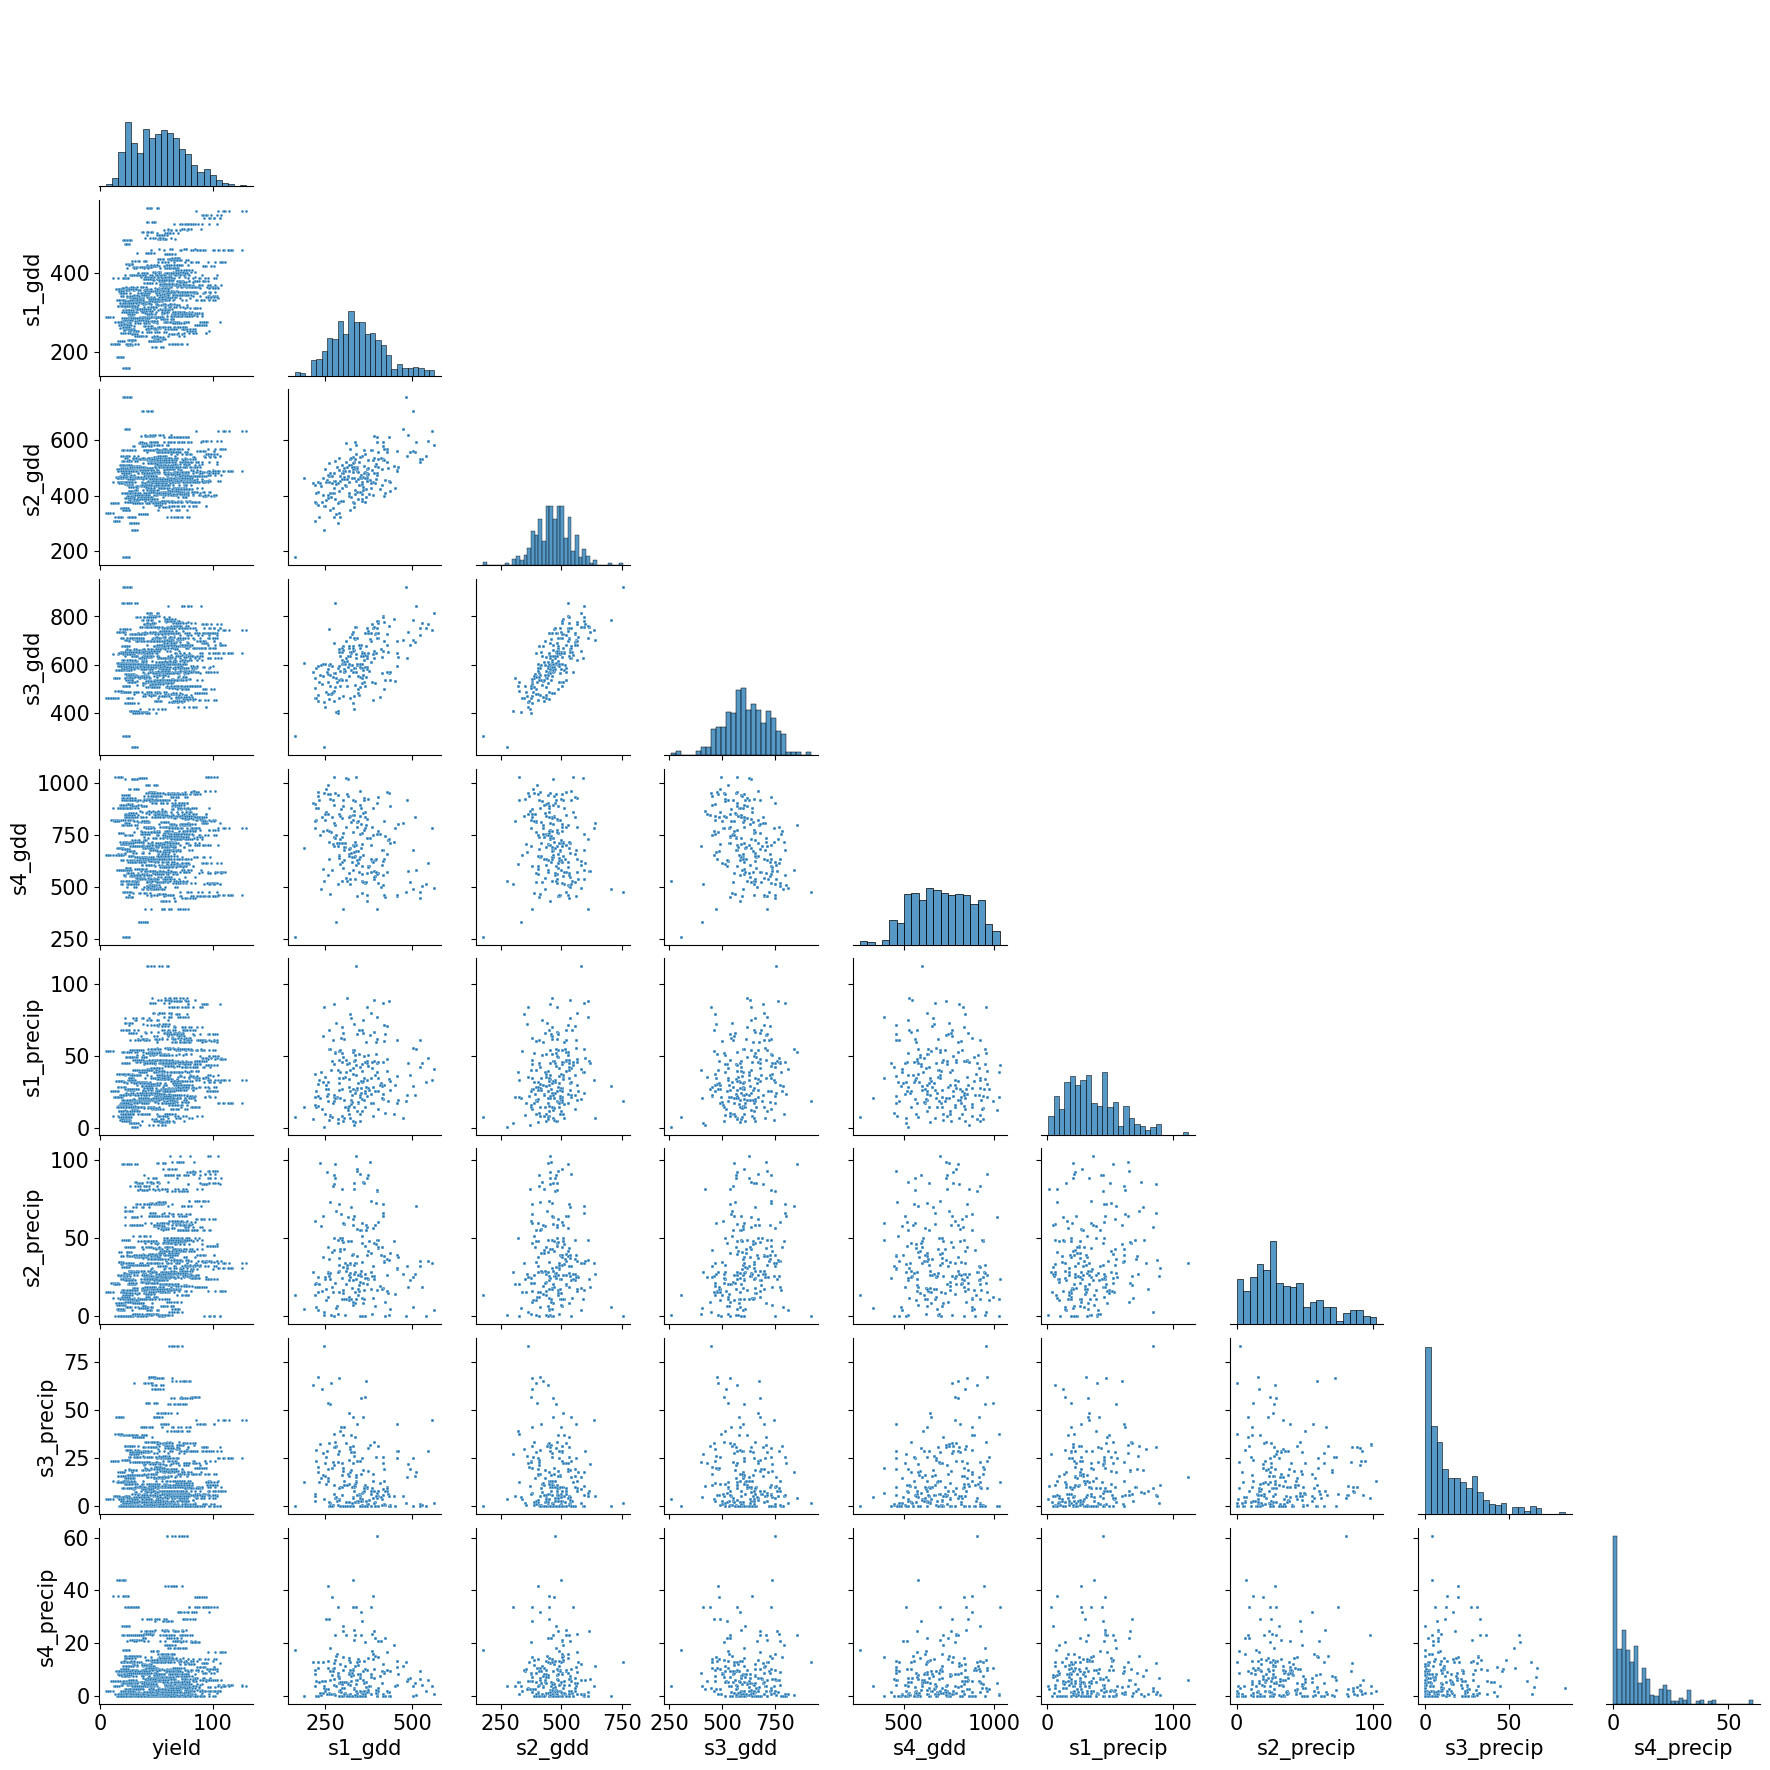

In [19]:
cols_ = ["yield"] + season_gdd_cols + season_precip_cols

my_scatter = sns.pairplot(df_season[cols_], size=2, corner=True, plot_kws={"s": 4})

fig_name = wheat_plot_dir + "4Season" + "_corr.png"
plt.savefig(fname=fig_name, dpi=200, bbox_inches="tight")

fig_name = wheat_plot_dir + "4Season" + "_corr.pdf"
plt.savefig(fname=fig_name, dpi=200, bbox_inches="tight")

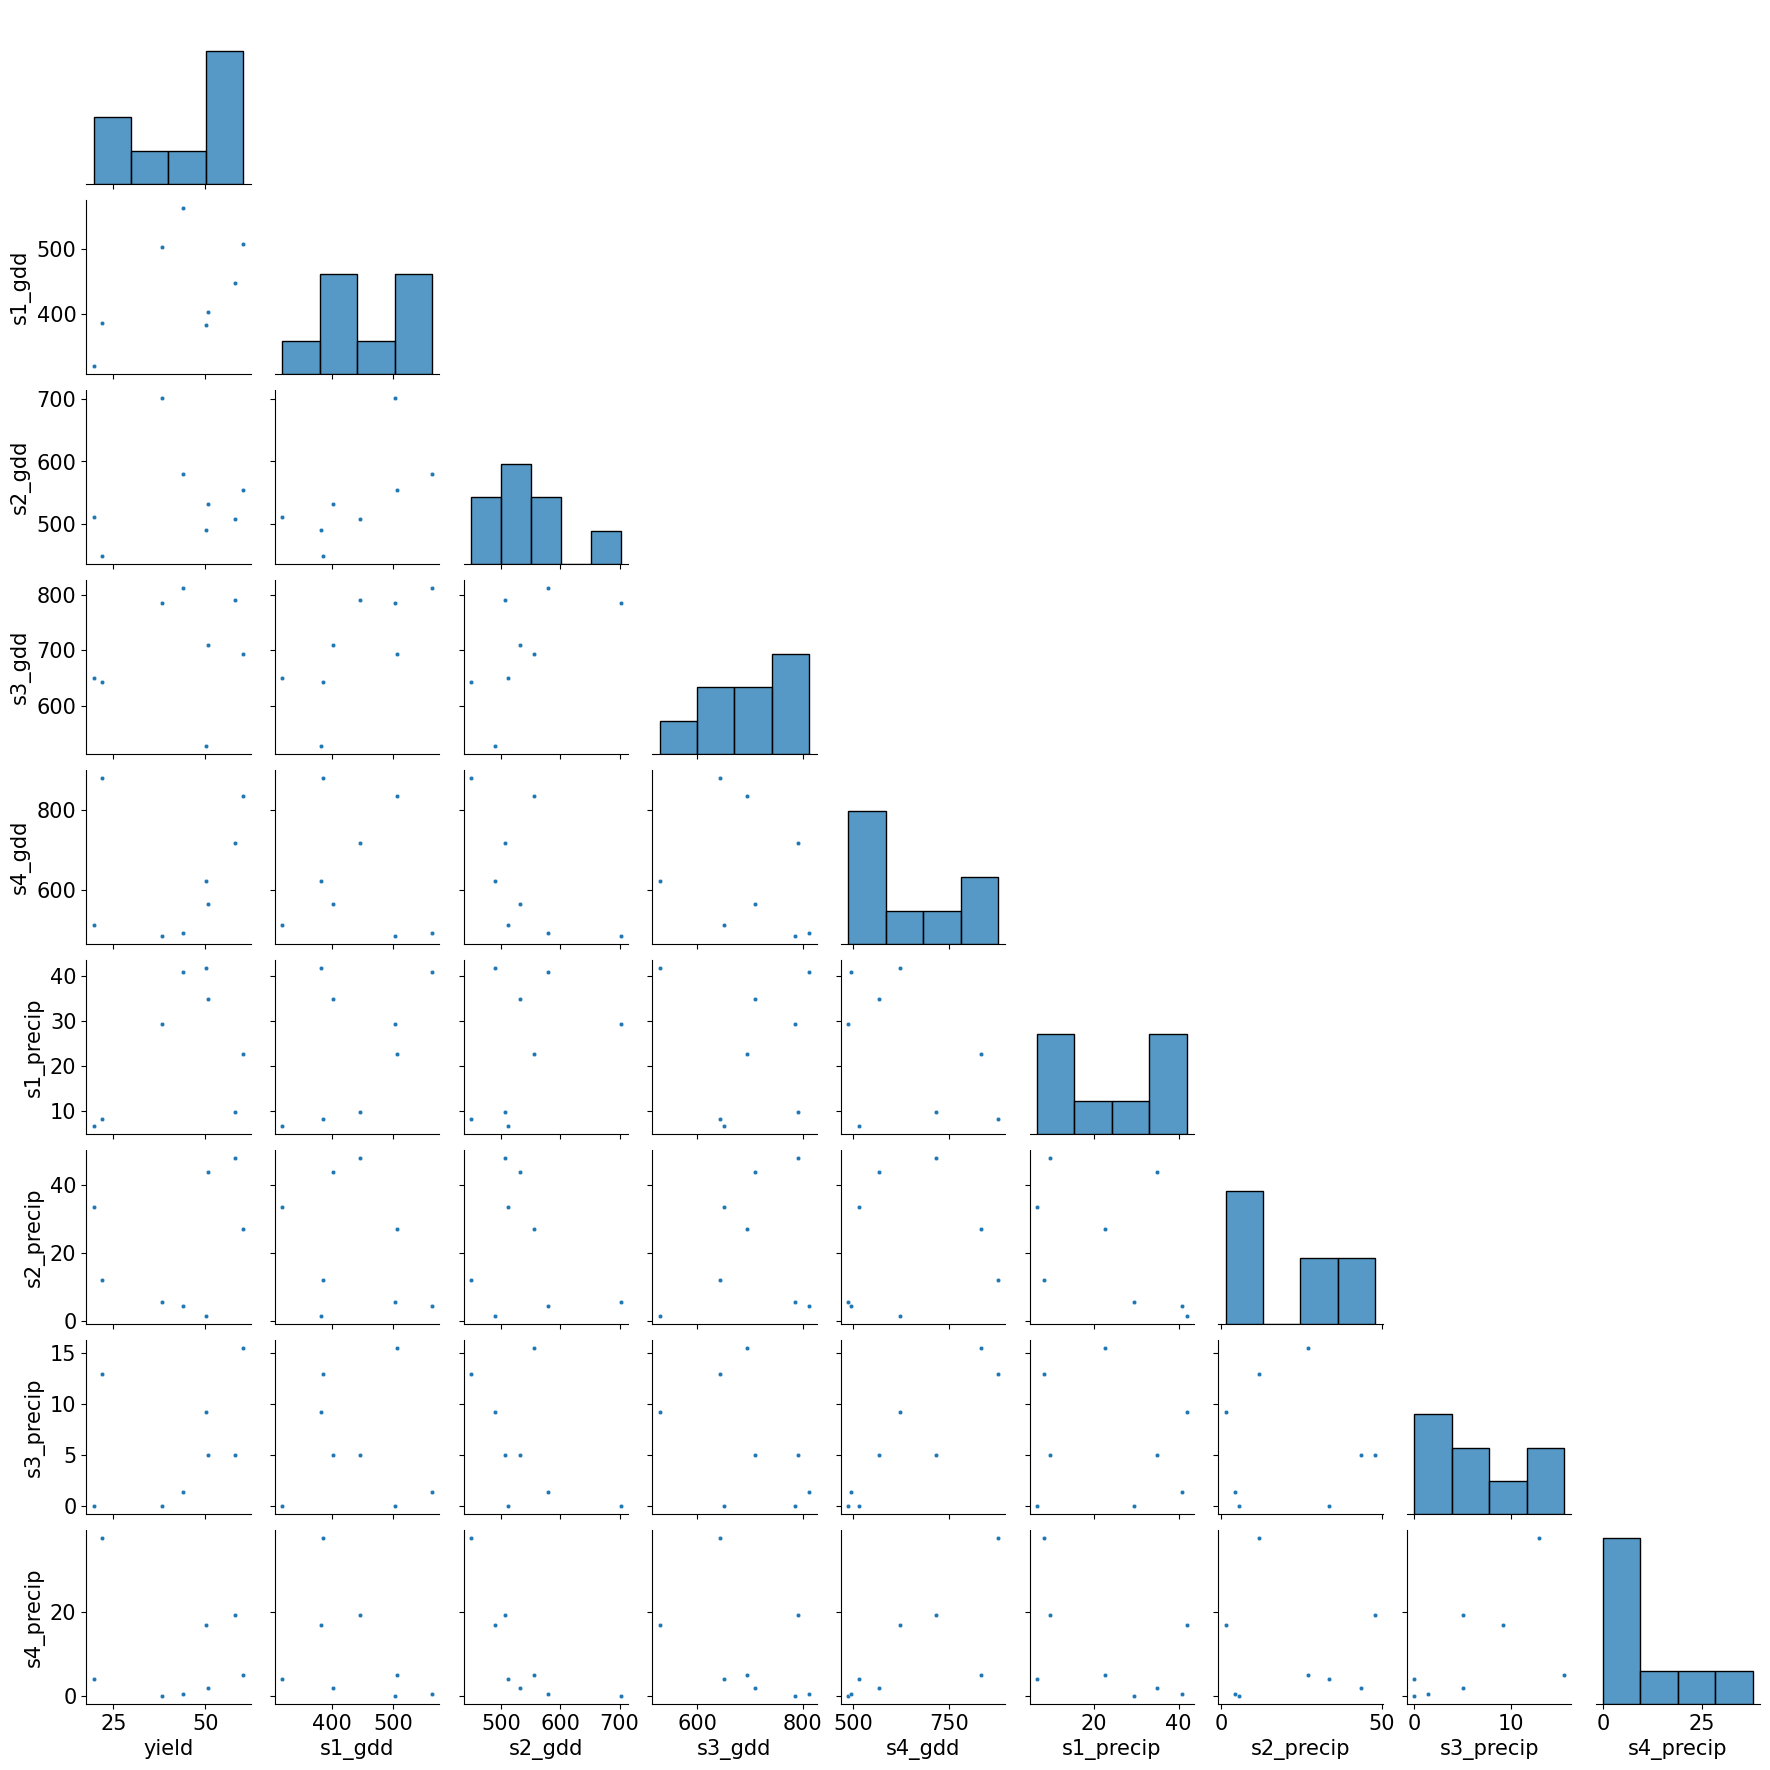

In [20]:
cols_ = ["yield"] + season_gdd_cols + season_precip_cols

loc_ = locations[0]
variety = varieties[10]
df_vari = df_season[(df_season["variety"] == variety) & (df_season["location"] == loc_)]


my_scatter = sns.pairplot(df_vari[cols_], size=2, corner=True, plot_kws={"s": 10})

fig_name = wheat_plot_dir + "4Season_" + variety + "_"  + loc_ + "_corr"
plt.savefig(fname=fig_name + ".png", dpi=200, bbox_inches="tight")
plt.savefig(fname=fig_name + ".pdf", dpi=200, bbox_inches="tight")

### for a given variety

In [21]:
df_season.head(2)

,location,year,variety,yield,s1_gdd,s2_gdd,s3_gdd,s4_gdd,s1_precip,s2_precip,s3_precip,s4_precip
0,Almira,2005,Alpowa,43.9,336.125,418.83,514.615,912.34,51.0,28.3,11.4,11.4
1,Almira,2005,Alturas,37.7,336.125,418.83,514.615,912.34,51.0,28.3,11.4,11.4


In [22]:
varieties

array(['Alpowa', 'Alturas', 'Louise', 'Nick', 'Wakanz', 'Zak', 'Whit',
       'Babe', 'Diva', 'Seahawk', 'Tekoa', 'Ryan', 'WB6341'], dtype=object)

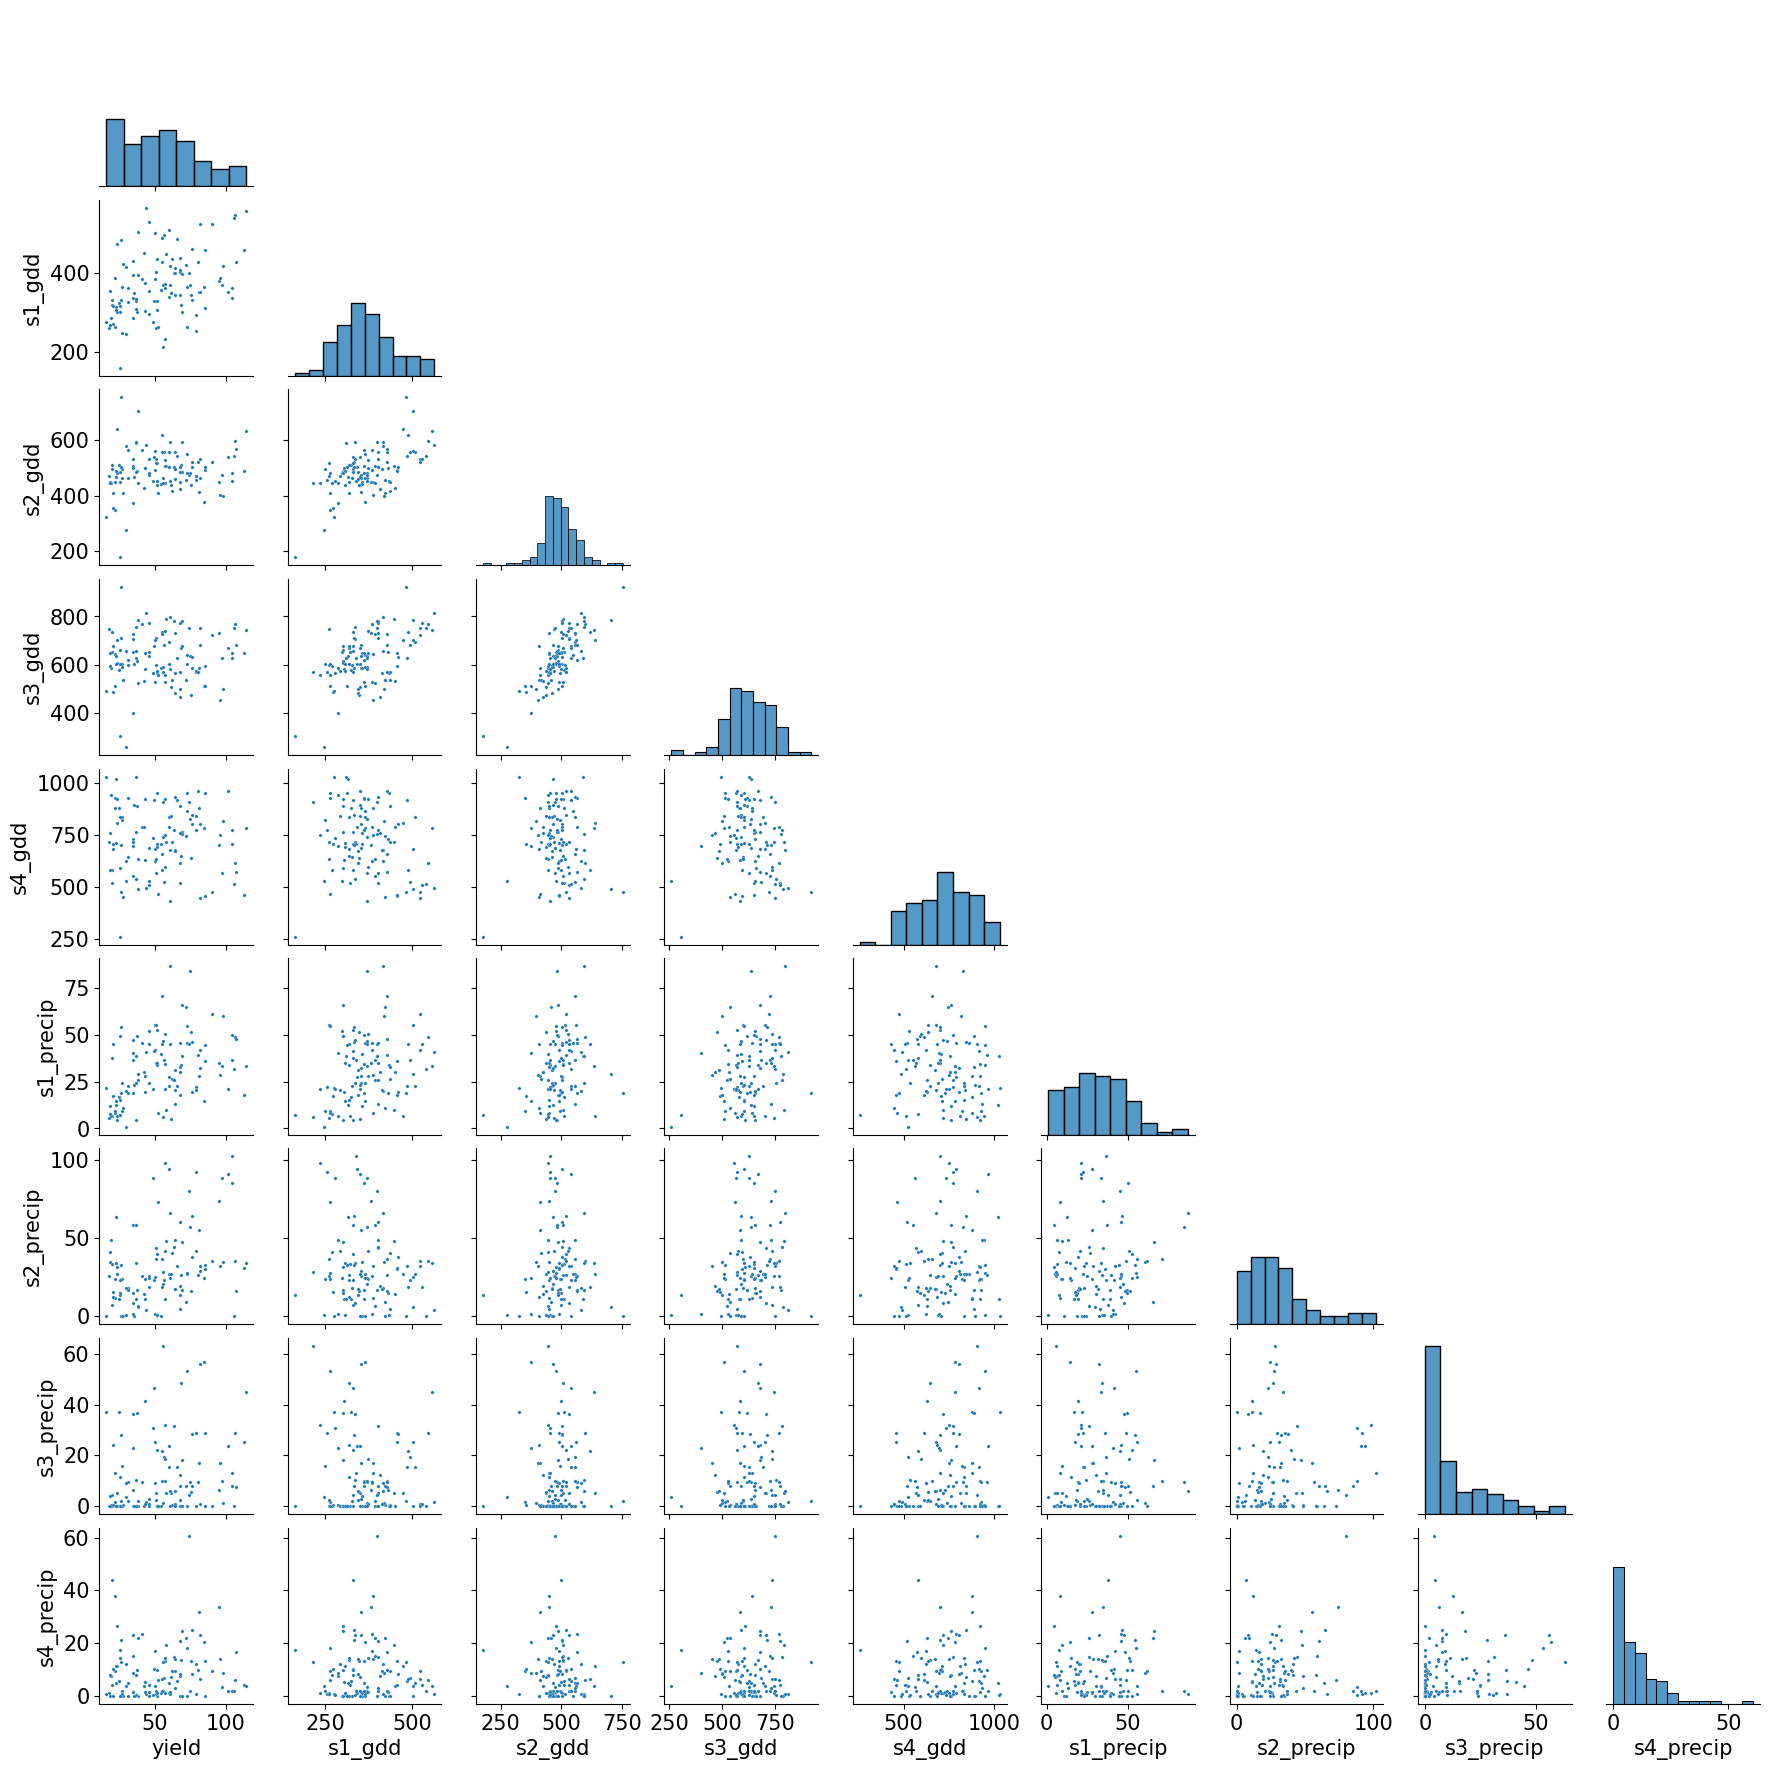

In [23]:
loc_ = locations[0]
variety = varieties[10]
df_vari = df_season[(df_season["variety"] == variety)]
my_scatter = sns.pairplot(df_vari[cols_], size=2, corner=True, plot_kws={"s": 6})

fig_name = wheat_plot_dir + "4Season_" + variety + "_corr"
plt.savefig(fname=fig_name + ".png", dpi=200, bbox_inches="tight")
plt.savefig(fname=fig_name + ".pdf", dpi=200, bbox_inches="tight")

### Not any correlation between yield and seasonal variables. What about annual?

May be correlations occur in higher dimension (i.e. not pairwise vars)?

In [24]:
dict_season = {"location" : list(df["location"]),
               "year" : list(df["year"]),
               "variety" : list(df["variety"]),
               "yield" : list(df["yield"]),
              }
df_year = pd.DataFrame(dict_season)
df_year.head(2)

,location,year,variety,yield
0,Almira,2005,Alpowa,43.9
1,Almira,2005,Alturas,37.7


In [25]:
gdd_cols = [x for x in df.columns if "gdd" in x]
precip_cols = [x for x in df.columns if "precip" in x]

df_year["all_gdd"] = df[gdd_cols].sum(axis=1)
df_year["all_precip"] = df[precip_cols].sum(axis=1)
df_year.head(2)

,location,year,variety,yield,all_gdd,all_precip
0,Almira,2005,Alpowa,43.9,2181.91,102.1
1,Almira,2005,Alturas,37.7,2181.91,102.1


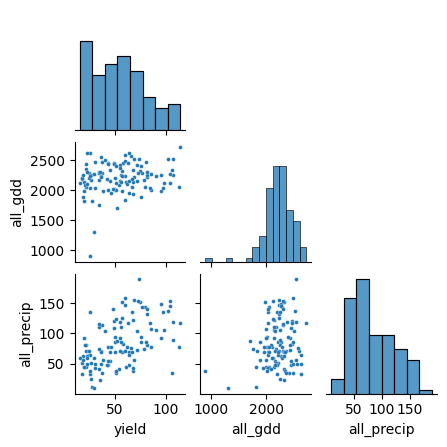

In [26]:
tick_legend_FontSize = 10
params = {"legend.fontsize": tick_legend_FontSize,  # medium, large
          # 'figure.figsize': (2, 2),
          "axes.labelsize": tick_legend_FontSize * 1,
          "axes.titlesize": tick_legend_FontSize * 2,
          "xtick.labelsize": tick_legend_FontSize * 1,
          "ytick.labelsize": tick_legend_FontSize * 1,
          "axes.titlepad": 10}
plt.rcParams.update(params)

cols_ = ["yield", "all_gdd", "all_precip"]

loc_ = locations[0]
variety = varieties[10]
df_vari = df_year[(df_year["variety"] == variety)]
my_scatter = sns.pairplot(df_vari[cols_], size=1.5, corner=True, plot_kws={"s": 8})

fig_name = wheat_plot_dir + "annual_" + variety + "_corr.pdf"
plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")

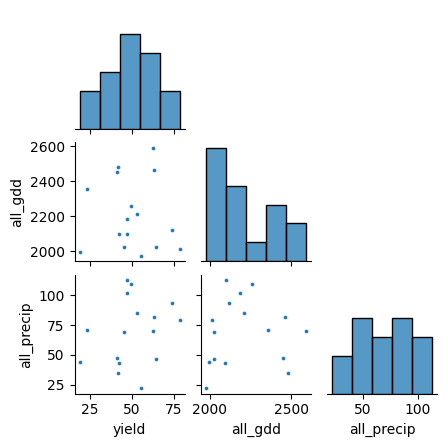

In [27]:
cols_ = ["yield", "all_gdd", "all_precip"]         

loc_ = locations[0]
variety = varieties[2]
df_vari = df_year[(df_year["variety"] == variety) & (df_year["location"] == loc_)]
my_scatter = sns.pairplot(df_vari[cols_], size=1.5, corner=True, plot_kws={"s": 8})

fig_name = wheat_plot_dir + "annual_" + variety + "_" + loc_ + "_corr.pdf"
plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")

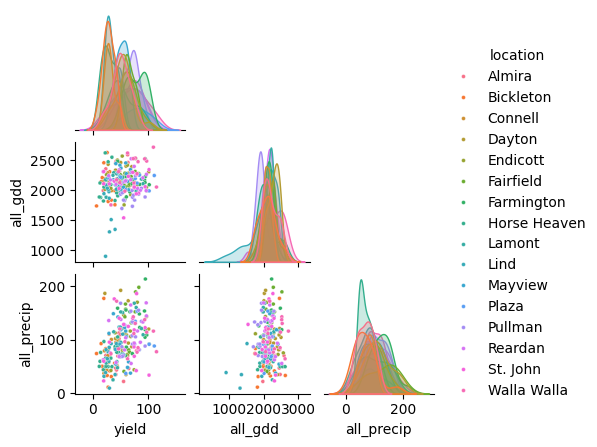

In [28]:
cols_ = ["yield", "all_gdd", "all_precip"]         

loc_ = locations[0]
variety = varieties[2]
df_vari = df_year[(df_year["variety"] == variety)]
my_scatter = sns.pairplot(df_vari[cols_ + ["location"]], hue="location", size=1.5, 
                          corner=True, plot_kws={"s": 8})

fig_name = wheat_plot_dir + "annual_" + variety + "_corr.pdf"
# plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")

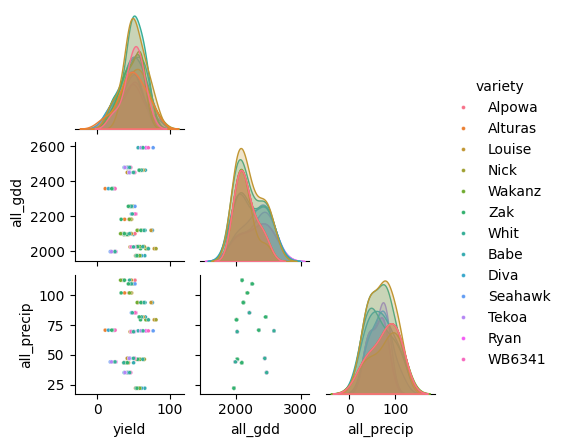

In [29]:
cols_ = ["yield", "all_gdd", "all_precip"]         

loc_ = locations[0]
variety = varieties[2]
df_vari = df_year[(df_year["location"] == loc_)]
my_scatter = sns.pairplot(df_vari[cols_ + ["variety"]], hue="variety", size=1.5, 
                          corner=True, plot_kws={"s": 8})

fig_name = wheat_plot_dir + "annual_" + loc_ + "_corr.pdf"
# plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")

### Linear Regression with annual data

In [30]:
from pysal.lib import weights
from pysal.model import spreg
from pysal.explore import esda

In [31]:
df_year.head(2)

,location,year,variety,yield,all_gdd,all_precip
0,Almira,2005,Alpowa,43.9,2181.91,102.1
1,Almira,2005,Alturas,37.7,2181.91,102.1


In [32]:
depen_var, indp_vars = "yield", ["all_precip"]

m5 = spreg.OLS_Regimes(y = df_year[depen_var].values, 
                       x = df_year[indp_vars].values, 
                       # Variable specifying neighborhood membership
                       regimes = df_year["variety"].tolist(),
              
                       # Variables to be allowed to vary (True) or kept
                       # constant (False). Here we set all to False
                       # cols2regi=[False] * len(indp_vars),
                        
                       # Allow the constant term to vary by group/regime
                       constant_regi="many",
                        
                       # Allow separate sigma coefficients to be estimated
                       # by regime (False so a single sigma)
                       regime_err_sep=False,
                       name_y=depen_var, # Dependent variable name
                       name_x=indp_vars)

m5_results = pd.DataFrame({"Coeff.": m5.betas.flatten(), # Pull out regression coefficients and
                           "Std. Error": m5.std_err.flatten(), # Pull out and flatten standard errors
                           "P-Value": [i[1] for i in m5.t_stat], # Pull out P-values from t-stat object
                           }, index=m5.name_x)

m5_results.transpose()

,Alpowa_CONSTANT,Alpowa_all_precip,Alturas_CONSTANT,Alturas_all_precip,Babe_CONSTANT,Babe_all_precip,Diva_CONSTANT,Diva_all_precip,Louise_CONSTANT,Louise_all_precip,...,Tekoa_CONSTANT,Tekoa_all_precip,WB6341_CONSTANT,WB6341_all_precip,Wakanz_CONSTANT,Wakanz_all_precip,Whit_CONSTANT,Whit_all_precip,Zak_CONSTANT,Zak_all_precip
Coeff.,2.514453e+01,2.310937e-01,23.935455,2.422625e-01,2.909115e+01,2.402135e-01,3.198295e+01,2.437202e-01,3.163481e+01,2.370203e-01,...,2.634656e+01,3.409117e-01,3.172484e+01,0.269787,2.870797e+01,2.250852e-01,3.020965e+01,2.446203e-01,2.756133e+01,0.193969
Std. Error,4.940779e+00,4.323352e-02,4.940779,4.323352e-02,3.862763e+00,3.816627e-02,3.791205e+00,3.750425e-02,3.434939e+00,3.300679e-02,...,4.615909e+00,5.002990e-02,4.911326e+00,0.055763,5.182867e+00,4.501767e-02,3.521175e+00,3.450669e-02,4.940779e+00,0.043234
P-Value,3.950103e-07,1.011392e-07,0.000001,2.405697e-08,7.718799e-14,3.832695e-10,6.391871e-17,1.033054e-10,8.359820e-20,9.882980e-13,...,1.324699e-08,1.267595e-11,1.329772e-10,0.000001,3.464448e-08,6.260927e-07,1.943414e-17,1.894302e-12,2.775689e-08,0.000008


In [33]:
depen_var, indp_vars = "yield", ["all_gdd"]

m5 = spreg.OLS_Regimes(y = df_year[depen_var].values,  x = df_year[indp_vars].values, 
                       regimes = df_year["variety"].tolist(),
                       constant_regi="many",          
                       regime_err_sep=False,
                       name_y=depen_var,
                       name_x=indp_vars)

m5_results = pd.DataFrame({"Coeff.": m5.betas.flatten(), # Pull out regression coefficients and
                           "Std. Error": m5.std_err.flatten(), # Pull out and flatten standard errors
                           "P-Value": [i[1] for i in m5.t_stat], # Pull out P-values from t-stat object
                           }, index=m5.name_x)

m5_results.transpose()

,Alpowa_CONSTANT,Alpowa_all_gdd,Alturas_CONSTANT,Alturas_all_gdd,Babe_CONSTANT,Babe_all_gdd,Diva_CONSTANT,Diva_all_gdd,Louise_CONSTANT,Louise_all_gdd,...,Tekoa_CONSTANT,Tekoa_all_gdd,WB6341_CONSTANT,WB6341_all_gdd,Wakanz_CONSTANT,Wakanz_all_gdd,Whit_CONSTANT,Whit_all_gdd,Zak_CONSTANT,Zak_all_gdd
Coeff.,7.181418,0.020464,13.744234,0.017313,13.366908,0.017602,20.683885,0.015622,20.927292,0.015614,...,15.786671,0.017746,15.634993,0.017035,8.466907,0.021433,18.126688,0.016292,-2.664718,0.024434
Std. Error,18.192545,0.008670,18.192545,0.008670,15.996004,0.007378,15.268015,0.007026,13.766763,0.006405,...,18.476196,0.008316,21.948366,0.009868,19.027066,0.009112,14.327168,0.006635,18.192545,0.008670
P-Value,0.693075,0.018354,0.450050,0.045966,0.403462,0.017137,0.175667,0.026308,0.128644,0.014874,...,0.392973,0.032974,0.476333,0.084455,0.656376,0.018765,0.205956,0.014151,0.883563,0.004876


In [34]:
depen_var, indp_vars = "yield", ["all_gdd", "all_precip"]

m5 = spreg.OLS_Regimes(y = df_year[depen_var].values, x = df_year[indp_vars].values, 
                       regimes = df_year["variety"].tolist(),
                       constant_regi="many", regime_err_sep=False,
                       name_y=depen_var, name_x=indp_vars)

m5_results = pd.DataFrame({"Coeff.": m5.betas.flatten(),
                           "Std. Error": m5.std_err.flatten(),
                           "P-Value": [i[1] for i in m5.t_stat],}, 
                          index=m5.name_x)
m5_results.transpose()

,Alpowa_CONSTANT,Alpowa_all_gdd,Alpowa_all_precip,Alturas_CONSTANT,Alturas_all_gdd,Alturas_all_precip,Babe_CONSTANT,Babe_all_gdd,Babe_all_precip,Diva_CONSTANT,...,WB6341_all_precip,Wakanz_CONSTANT,Wakanz_all_gdd,Wakanz_all_precip,Whit_CONSTANT,Whit_all_gdd,Whit_all_precip,Zak_CONSTANT,Zak_all_gdd,Zak_all_precip
Coeff.,11.489398,0.007212,0.218049,18.426629,0.002909,2.369999e-01,3.111324,0.012434,2.313157e-01,11.142555,...,0.261102,12.545377,0.008580,0.209725,9.448033,0.010045,2.360122e-01,0.659779,0.014208,0.168270
Std. Error,16.600412,0.008373,0.045677,16.600412,0.008373,4.567723e-02,14.673365,0.006777,3.835051e-02,13.994995,...,0.055958,17.360876,0.008799,0.047556,13.116527,0.006115,3.479180e-02,16.600412,0.008373,0.045677
P-Value,0.488950,0.389152,0.000002,0.267136,0.728260,2.346210e-07,0.832100,0.066687,1.947435e-09,0.426026,...,0.000003,0.470001,0.329609,0.000011,0.471420,0.100598,1.562667e-11,0.968301,0.089875,0.000236


In [35]:
depen_var, indp_vars = "yield", ["all_gdd", "all_precip"]

m5 = spreg.OLS(y = df_year[depen_var].values, x = df_year[indp_vars].values, 
               name_y=depen_var, name_x=indp_vars)

m5_results = pd.DataFrame({"Coeff.": m5.betas.flatten(),
                           "Std. Error": m5.std_err.flatten(),
                           "P-Value": [i[1] for i in m5.t_stat],}, 
                          index=m5.name_x)
m5_results.transpose()

,CONSTANT,all_gdd,all_precip
Coeff.,3.690584,1.320452e-02,2.139795e-01
Std. Error,4.331169,2.024280e-03,1.155770e-02
P-Value,0.394265,8.775779e-11,1.449142e-70


In [36]:
df_year.head(2)

,location,year,variety,yield,all_gdd,all_precip
0,Almira,2005,Alpowa,43.9,2181.91,102.1
1,Almira,2005,Alturas,37.7,2181.91,102.1


### Take average of yield per location, year!
and see if that solves the problem of wide range of yields

In [37]:
df_year_avg = df_year[["location", "year", "yield"]].copy()
df_year_avg = df_year_avg.groupby(["location", "year"]).mean().reset_index(drop=False)


df_year_weather = df_year[["location", "year", "all_gdd", "all_precip"]].copy()
df_year_weather.drop_duplicates(inplace=True)

df_year_avg = pd.merge(df_year_avg, df_year_weather, on=["location", "year"], how="left")
df_year_avg.head(2)

,location,year,yield,all_gdd,all_precip
0,Almira,2005,42.088889,2181.91,102.1
1,Almira,2006,71.019048,2014.06,79.5


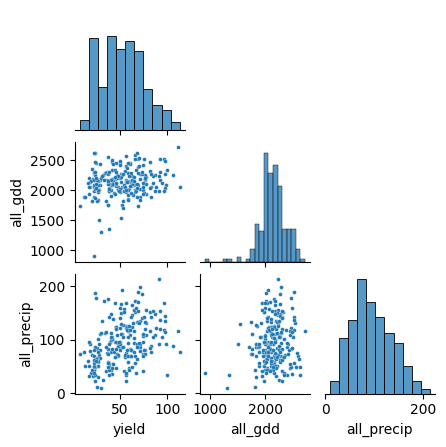

In [38]:
cols_ = ["yield", "all_gdd", "all_precip"]         
my_scatter = sns.pairplot(df_year_avg[cols_ ], size=1.5, corner=True, plot_kws={"s": 8})
fig_name = wheat_plot_dir + "annual_" + loc_ + "_corr.pdf"
# plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")

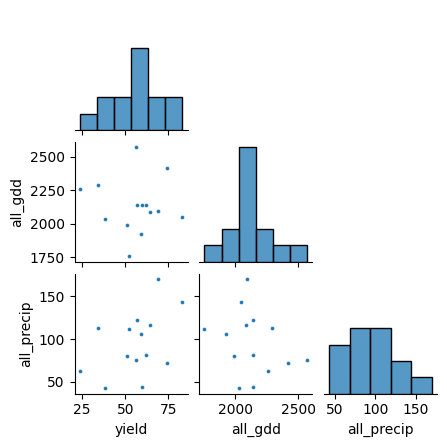

In [39]:
cols_ = ["yield", "all_gdd", "all_precip"]         
loc_ = locations[4]
df_vari = df_year_avg[(df_year_avg["location"] == loc_)]
my_scatter = sns.pairplot(df_vari[cols_ ], size=1.5, corner=True, plot_kws={"s": 8})

fig_name = wheat_plot_dir + "annual_" + loc_ + "_corr.pdf"
# plt.savefig(fname=fig_name, dpi=300, bbox_inches="tight")

## Seasonal Average

In [40]:
season_gdd_cols = [x for x in df_season if "gdd" in x]
season_precip_cols = [x for x in df_season if "precip" in x]

In [41]:
df_season_avg = df_season[["location", "year", "yield"]].copy()
df_season_avg = df_season_avg.groupby(["location", "year"]).mean().reset_index(drop=False)
df_season_avg.head(2)

df_season_weather = df_season[["location", "year"] + season_gdd_cols + season_precip_cols].copy()
print (df_season_weather.shape)
df_season_weather.drop_duplicates(inplace=True)
print (df_season_weather.shape)

df_season_avg = pd.merge(df_season_avg, df_season_weather, on=["location", "year"], how="left")
df_season_avg.head(2)

(1931, 10)
(229, 10)


,location,year,yield,s1_gdd,s2_gdd,s3_gdd,s4_gdd,s1_precip,s2_precip,s3_precip,s4_precip
0,Almira,2005,42.088889,336.125,418.83,514.615,912.340,51.0,28.3,11.4,11.4
1,Almira,2006,71.019048,302.105,465.35,570.600,676.005,6.7,59.0,10.8,3.0


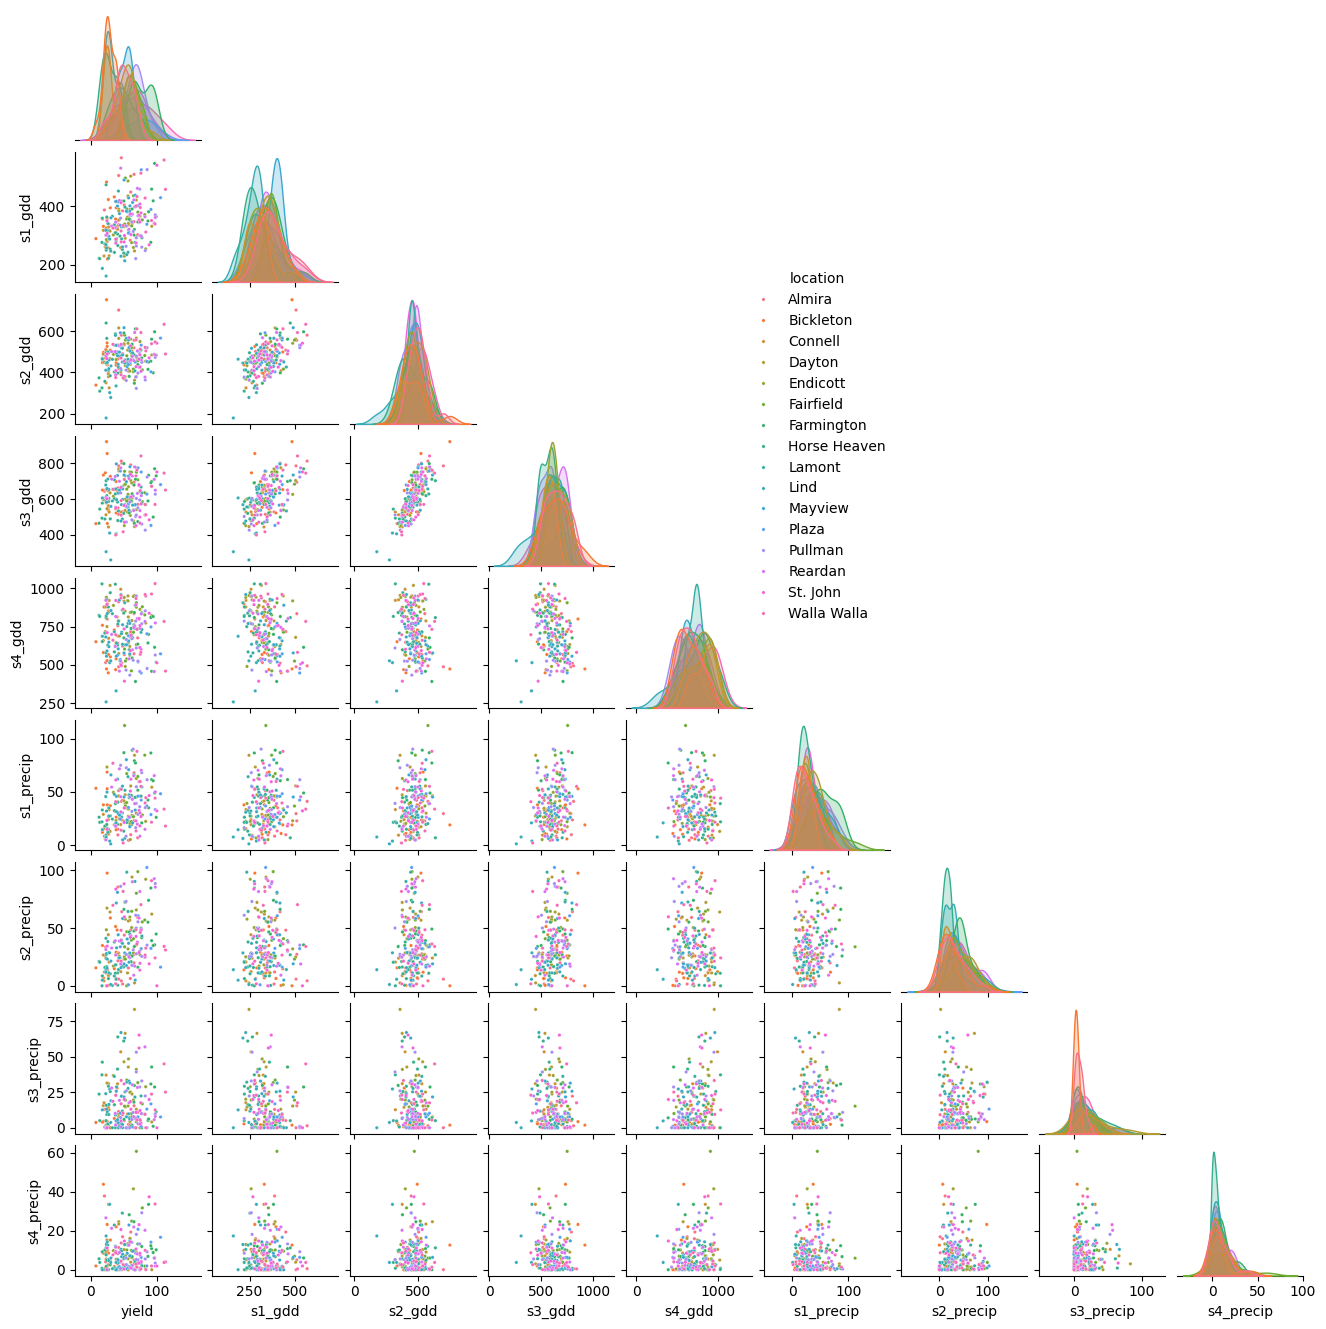

In [45]:
cols_ = ["yield"] +  season_gdd_cols + season_precip_cols

loc_ = locations[0]
# df_vari = df_season[(df_season["variety"] == variety)]
my_scatter = sns.pairplot(df_season_avg[cols_ + ["location"]], hue="location",
                          size=1.5, corner=True, plot_kws={"s": 6})

sns.move_legend(my_scatter, "upper left", bbox_to_anchor=(0.5, .8))

fig_name = wheat_plot_dir + "4Season_averaged_corr"
plt.savefig(fname=fig_name + ".png", dpi=200, bbox_inches="tight")
plt.savefig(fname=fig_name + ".pdf", dpi=200, bbox_inches="tight")